In [88]:
import tensorflow as tf
import kagglehub
from datasets import load_dataset
from PIL import Image
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

In [89]:
dataset = load_dataset("naver-clova-ix/cord-v2", split="test")
# gt = dataset[0]['ground_truth'] 
# print(gt)

In [90]:
image_path = dataset[0]['image']  # Sudah dalam bentuk PIL.Image
# image = image.convert("RGB")  # Pastikan formatnya RGB

In [92]:
# Preprocessing gambar
image = np.array(image)
image_resized = cv2.resize(image, (640, 640))  # Resize sesuai dengan input model
image_array = np.array(image_resized) / 255.0  # Normalisasi
image_array = np.expand_dims(image_array, axis=0)  # Tambahkan batch dimension

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError

model = load_model('/kaggle/input/bbox_model_v1/keras/default/1/bbox_model.h5', 
                   custom_objects={'mse': MeanSquaredError()})

In [93]:
# Lakukan prediksi
predictions = model.predict(image_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step


In [96]:
print("Classification output:", predictions[1][0].min(), predictions[1][0].max())
print("Bbox output:", predictions[0][0].min(), predictions[0][0].max())

Classification output: 0.0 1.0508088e-06
Bbox output: -1.6880794 1.8132435


In [ ]:
label_map = {'item_name': 0, 'quantity': 1, 'price': 2}

In [99]:
def decode_predictions(predictions, label_map, score_threshold=0, down_ratio=4, image_width=640, image_height=640):
    bbox_output = predictions[0][0]  # Ambil batch pertama
    class_output = predictions[1][0]
    offset_output = predictions[2][0]
    
    output_size = class_output.shape[0]  # Asumsi square output
    detections = []
    
    for y in range(output_size):
        for x in range(output_size):
            class_probs = class_output[y, x, :]
            max_class = tf.argmax(class_probs)
            max_score = class_probs[max_class]
            
            if max_score > score_threshold:
                # Decode bounding box
                cx_offset, cy_offset, w, h = bbox_output[y, x, :]
                
                # Hitung center point dalam koordinat output
                cx = (x + cx_offset) * down_ratio
                cy = (y + cy_offset) * down_ratio
                
                # Konversi ke koordinat gambar asli
                x_min = int(cx - w * image_width / 2)
                y_min = int(cy - h * image_height / 2)
                x_max = int(cx + w * image_width / 2)
                y_max = int(cy + h * image_height / 2)
                
                # Normalisasi dan kliping koordinat ke dalam rentang gambar
                x_min = max(0, min(x_min, image_width - 1))
                y_min = max(0, min(y_min, image_height - 1))
                x_max = max(0, min(x_max, image_width - 1))
                y_max = max(0, min(y_max, image_height - 1))
                
                # Hanya tambahkan deteksi jika bounding box valid
                if x_max > x_min and y_max > y_min:  # Pastikan width dan height positif
                    detections.append({
                        "class": max_class,
                        "score": float(max_score),  # Konversi ke float native Python
                        "bbox": [x_min, y_min, x_max, y_max]
                    })
    
    return detections

# Decode predictions dengan dimensi gambar yang jelas
detections = decode_predictions(predictions, label_map, image_width=640, image_height=640)
print(detections)

[{'class': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'score': 4.0874793133527376e-11, 'bbox': [0, 0, 10, 60]}, {'class': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'score': 2.2883705022049006e-13, 'bbox': [9, 0, 14, 115]}, {'class': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'score': 6.273886575189347e-13, 'bbox': [16, 0, 23, 98]}, {'class': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'score': 1.2337917146276745e-12, 'bbox': [8, 0, 39, 113]}, {'class': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'score': 1.747651827942176e-12, 'bbox': [8, 0, 47, 124]}, {'class': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'score': 2.0794217042707785e-12, 'bbox': [9, 0, 54, 131]}, {'class': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'score': 2.2554690320281123e-12, 'bbox': [11, 0, 60, 133]}, {'class': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'score': 2.3413653828241454e-12, 'bbox': [13, 0, 66, 133]}, {'class': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'score': 2.4203185029075813e-12, 

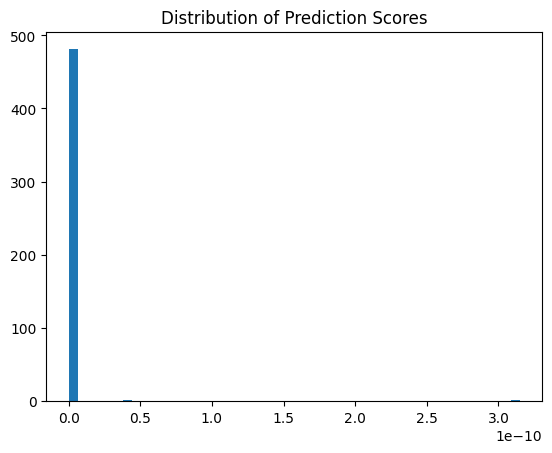

In [100]:
scores = [float(d['score']) for d in detections]
plt.hist(scores, bins=50)
plt.title('Distribution of Prediction Scores')
plt.show()